<a href="https://colab.research.google.com/github/NiallJeffrey/MomentNetworks/blob/master/notebooks/delfi_failure_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Show vanilla delfi estimation in full dimension
## Summary: DELFI fails with 20 parameters and 100000 training data
## Comparison: MomentNetwork gets ~4% error of average marginal variance. High-dim DELFI completely fails (92% error)

# Load modules

In [1]:
# !pip install tensorflow==1.15
!pip install tensorflow-gpu==1.15
!pip install git+https://github.com/justinalsing/pydelfi.git

     |████████████████████████████████| 411.5MB 40kB/s 
     |████████████████████████████████| 3.8MB 39.7MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 512kB 36.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=f29cefe65c56a742a52d93b60f8526f558e8c572d096c7a8e8c13d2b6dd33ce1
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorflow-estimator<2.4.0,>=2.3.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing i

In [2]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import random
import emcee as mc
import getdist
from getdist import plots, MCSamples
import pydelfi.priors as priors
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import scipy.interpolate as interpolate
import time
import tensorflow as tf
import pydelfi.score as score
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

# Training data

In [3]:
size=20
n_training = 100000
cov_signal_fourier = np.identity(size)*np.logspace(size,size*0.9,size)/np.sum(np.logspace(size,size*0.9,size))
cov_noise = np.identity(size)*0.1
cov_noise_inv = np.linalg.pinv(cov_noise)

In [4]:
training_z = np.random.multivariate_normal(np.zeros(size),cov_signal_fourier,n_training) + \
                  1j*np.random.multivariate_normal(np.zeros(size), cov_signal_fourier,n_training)
training_z = np.fft.fft(training_z).real

training_data = training_z + np.random.multivariate_normal(np.zeros(size),cov_noise,n_training)


training_z_obs = training_z[0]
training_data_obs = training_data[0]
training_z = training_z[1:]
training_data = training_data[1:]

In [5]:
cov_signal = np.identity(size)*0.

for i in range(n_training-1):
  cov_signal += np.outer(training_z[i],training_z[i]) 

cov_signal = cov_signal/np.float(n_training-1.)

cov_signal_inv = np.linalg.pinv(cov_signal)

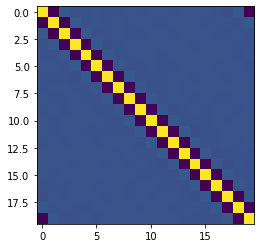

In [6]:
plt.imshow(cov_signal_inv)

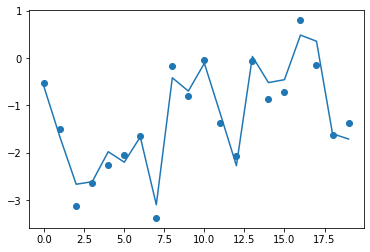

In [7]:
plt.plot(training_z_obs)
plt.scatter(np.arange(size),training_data_obs)

# Delfi

In [8]:
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=size,
                                                 n_data=size, n_hiddens=[size*4,size*4],
                                                 n_mades=size, act_fun=tf.tanh, index=0)]

In [9]:
# Set priors
lower = np.array([-10]*size)
upper = np.array([10]*size)
prior = priors.Uniform(lower, upper)

In [10]:
param_names = []
for i in range(size):
    param_names.append(str('\theta_' + str(i)))

In [11]:
DelfiEnsemble = delfi.Delfi(training_data_obs, prior, NDEs,
                            param_limits = [lower, upper],
                            param_names = param_names, 
                            results_dir = 'temp/')

In [12]:
DelfiEnsemble.load_simulations(training_data, training_z)

In [13]:
DelfiEnsemble.train_ndes(batch_size=4000)

In [14]:
training_data_obs

array([-0.52019349, -1.50702619, -3.12366229, -2.64188742, -2.26630548,
       -2.05729437, -1.64662132, -3.37551441, -0.17459897, -0.80100469,
       -0.03669885, -1.36366253, -2.07918754, -0.07352192, -0.86099196,
       -0.70937565,  0.79537263, -0.15429895, -1.63021219, -1.37103325])

In [15]:
DelfiEnsemble.log_likelihood_stacked(training_z_obs,
                                    data=training_data_obs)[0][0]

-2.6046295

# Sampling

In [16]:
def log_prior(theta, data,cov_signal_inv):
    return -0.5*np.inner(theta,np.inner(cov_signal_inv,theta))

def log_likelihood(theta, data,cov_noise_inv):
    return -0.5*np.inner(theta-data,np.inner(cov_noise_inv,theta-data))

def log_posterior_delfi(theta, data,cov_signal_inv):
    return log_prior(theta, data,cov_signal_inv) + DelfiEnsemble.log_likelihood_stacked(theta,data=data) 

def log_posterior_likelihood(theta, data,cov_signal_inv,cov_noise_inv):
    return log_prior(theta, data,cov_signal_inv)  + log_likelihood(theta, data,cov_noise_inv)



In [17]:
def initial_parameters(theta, relative_sigma):
    """
    This is not randomise the initial position of the
    :param theta: list/array of parameter values
    :param relative_sigma: controls variance of random draws
    :return: the theta array but with random shifts
    """
    theta = np.array(theta)
    return np.random.normal(theta, np.abs(theta * relative_sigma))

In [18]:
n_dim=size
n_burn=100
n_steps = 10000
n_walkers = 2* n_dim


sampler_delfi = mc.EnsembleSampler(n_walkers, n_dim, log_posterior_delfi,
                             args=(training_data_obs,cov_signal_inv,))

sampler_likelihood = mc.EnsembleSampler(n_walkers, n_dim, log_posterior_likelihood,
                             args=(training_data_obs,cov_signal_inv,cov_noise_inv,))

In [19]:
theta_expected_mean = [0.1]*size

theta0 = np.array([list(initial_parameters(theta_expected_mean, 1)) for i in range(n_walkers)])

In [23]:
t = time.time()
_ =sampler_delfi.run_mcmc(theta0, n_steps)

print(time.time() - t)

flat_samples_delfi = sampler_delfi.get_chain(discard=n_burn, flat=True)
print(flat_samples_delfi.shape)

(214560, 20)


In [21]:
t = time.time()
_ =sampler_likelihood.run_mcmc(theta0, n_steps) 

print(time.time() - t)

flat_samples_likelihood = sampler_likelihood.get_chain(discard=n_burn, flat=True)
print(flat_samples_likelihood.shape)

10.465494394302368
(396000, 20)


Removed no burn in
Removed no burn in


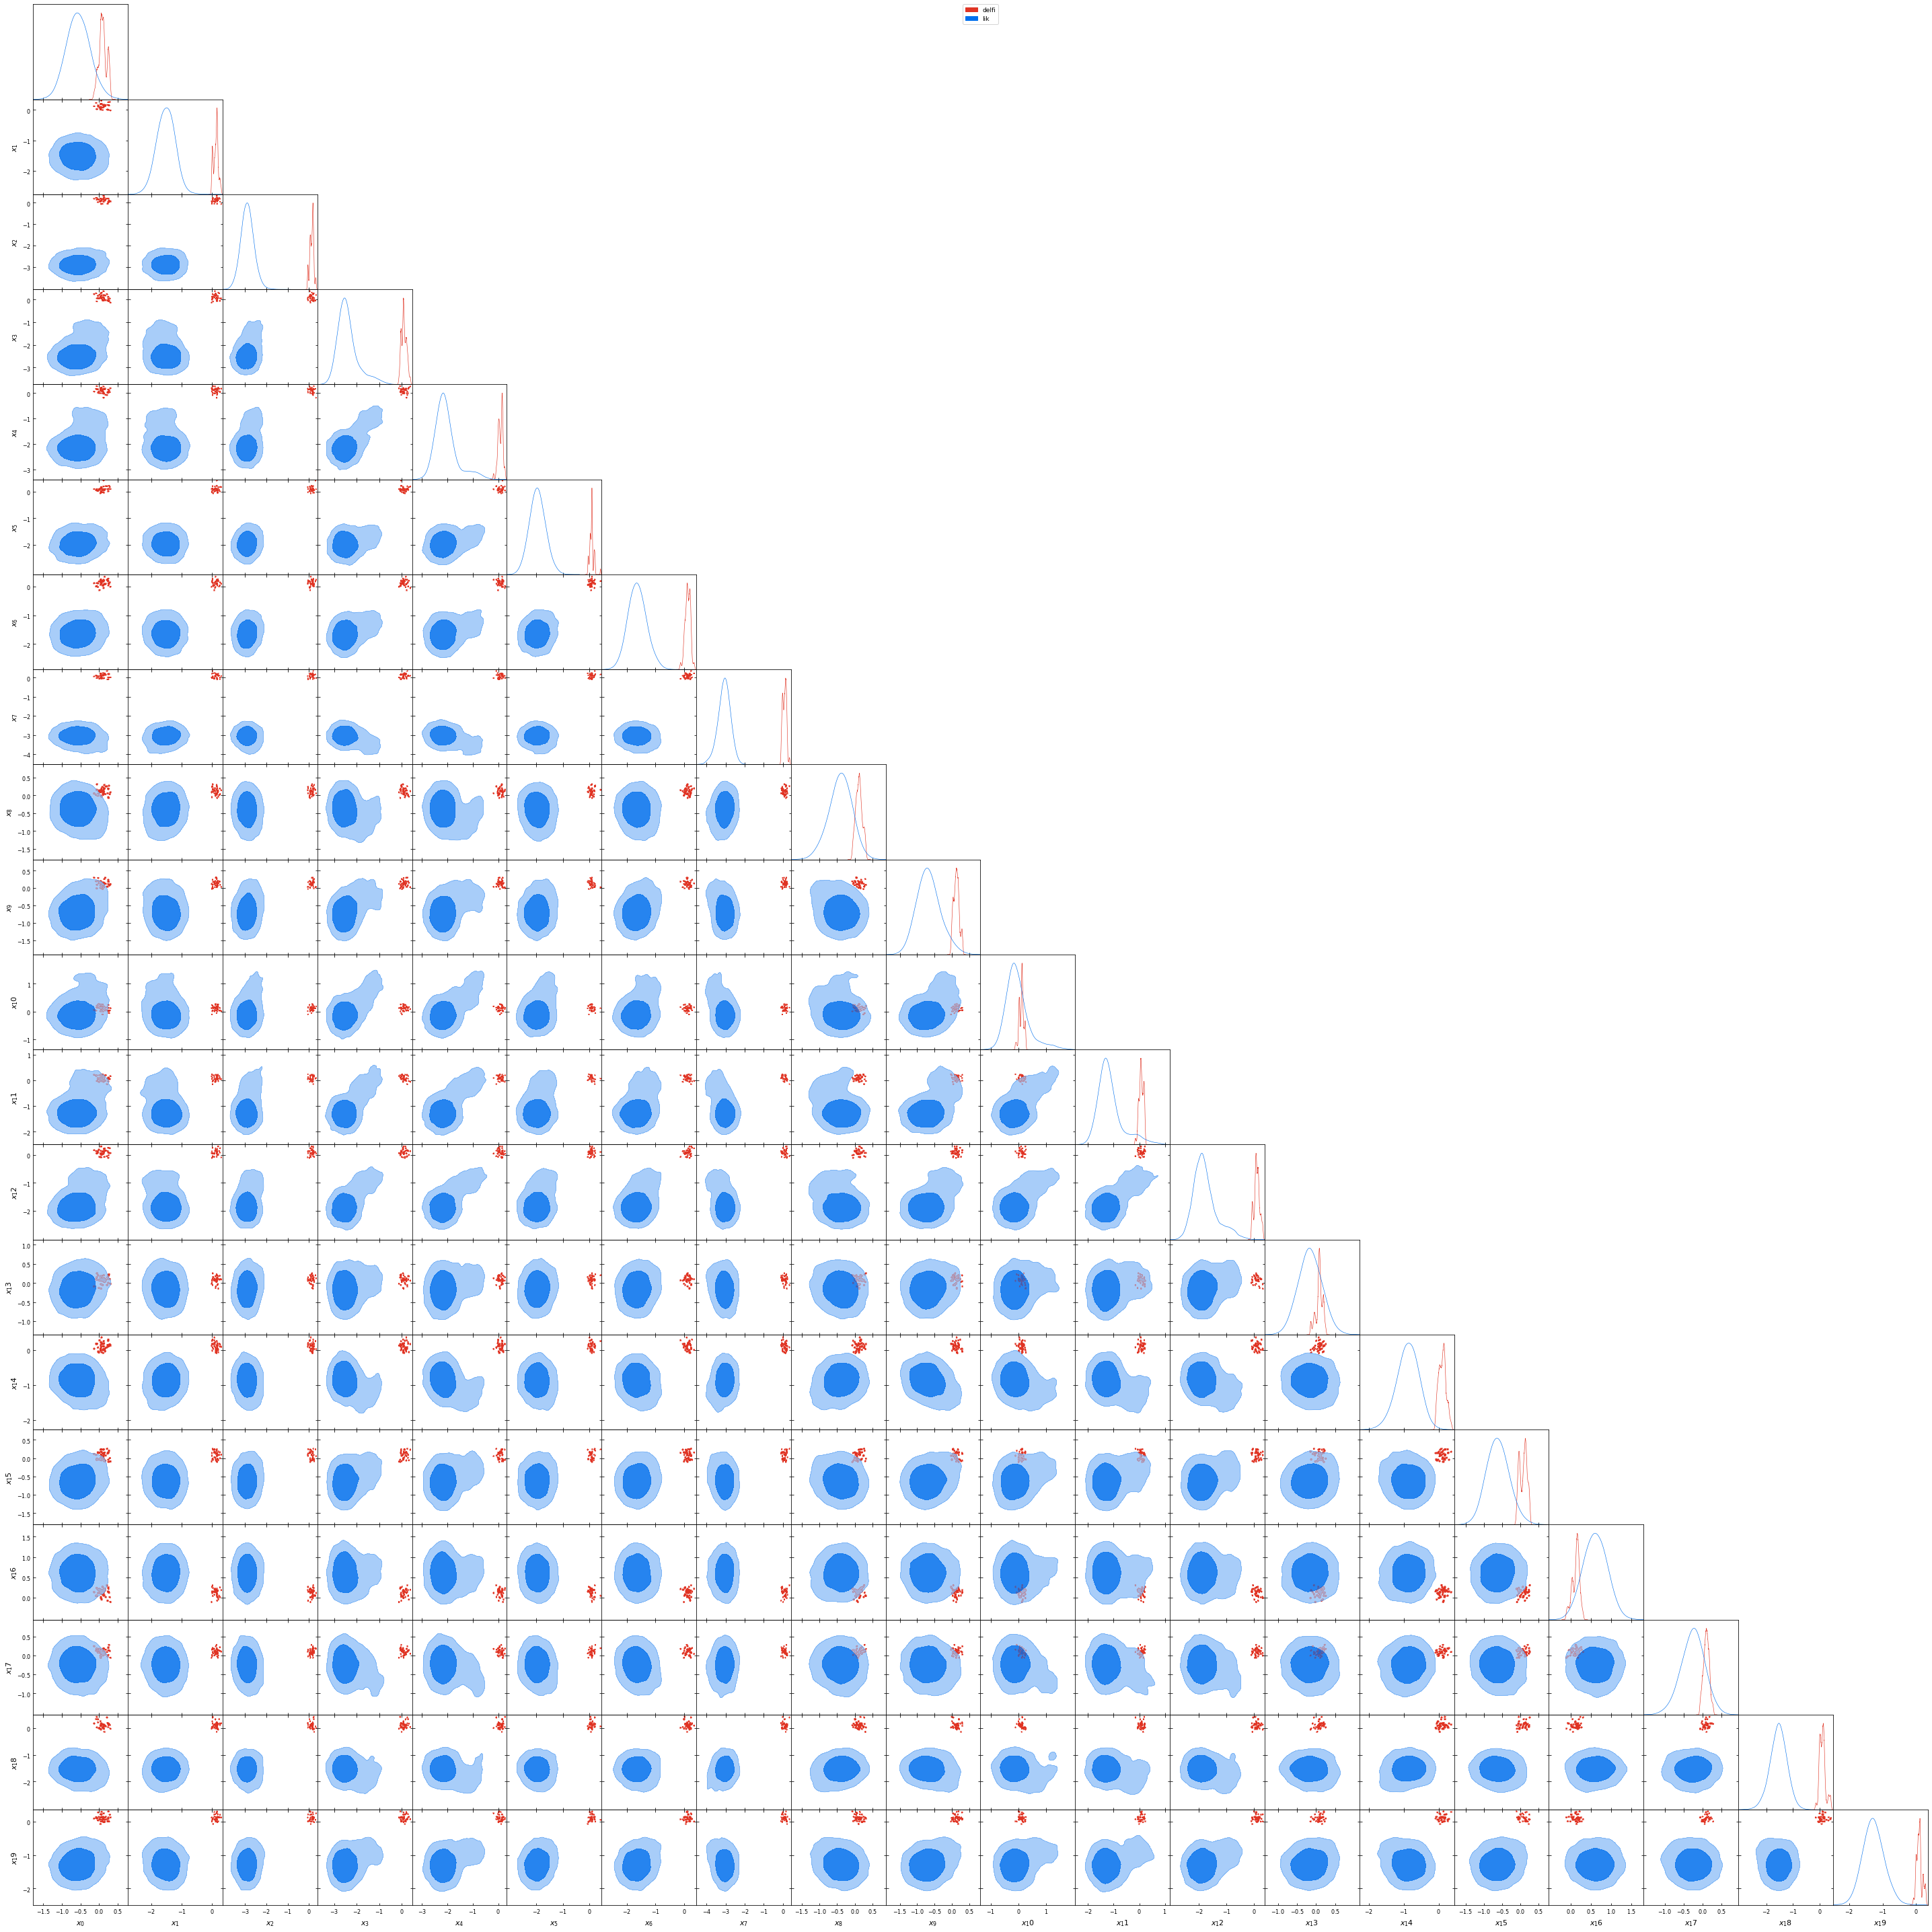

In [24]:
names = ["x%s"%i for i in range(size)]
labels =  ["x_%s"%i for i in range(size)]
samples = MCSamples(samples=flat_samples_delfi,names = names, labels = labels, label='delfi',
               settings={'smooth_scale_2D':1})
samples2 = MCSamples(samples=flat_samples_likelihood,names = names, labels = labels, label='lik',
               settings={'smooth_scale_2D':1})

g = plots.get_subplot_plotter()
g.triangle_plot([samples, samples2], filled=True)

# Compare DELFI marginal variance with known MCMC 

## $\Delta = \frac{1}{N} \sum_i^N \Big[ \frac{\mathrm{Var}_{MC} - \mathrm{Var}_{pred}}{\mathrm{Var}_{MC}} \Big]_{\theta_i}$ 

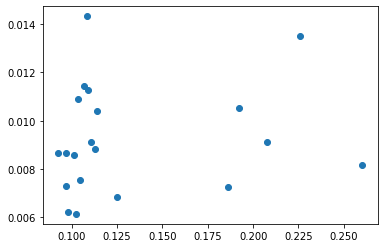

In [25]:
_ = plt.scatter(np.var(flat_samples_likelihood,axis=0), np.var(flat_samples_delfi,axis=0))

In [26]:
delta_stat = np.mean(1.-  np.var(flat_samples_delfi,axis=0)/np.var(flat_samples_likelihood,axis=0))
print(delta_stat)

0.9239216635480318
